In [1]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)
len(df)

779223

In [3]:
# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']

# Further group raw_inp_vars: a list of categories that will need to be bucketed for visualization, and those that won't
bucket_raw = ['AGEP', 'Off_Threshold', 'PreTaxIncome_PU', 'WKHP']
ok_raw = [var for var in raw_inp_vars if var not in bucket_raw]

id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']

acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']

nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']

output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']

all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

print('Number of columns in groups: ' + str(len(all_columns)))
print('Total columns in dataframe: ' + str(len(df.columns)))
# Double-check that all of the columns in the dataframe are assigned to one and only one group
print("Set of all dataframe columns that don't appear in a group: " + str(set(df.columns).difference(set(all_columns))))

Number of columns in groups: 80
Total columns in dataframe: 80
Set of all dataframe columns that don't appear in a group: set()


In [4]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

In [5]:
# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

In [6]:
# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

# List out the categories so we can check that it makes sense
for col in dict(raw_codes, **nyc_codes):
    print(col + ': ' + str(cats[col].unique()))

Boro: ['Brooklyn' 'Queens' 'Bronx' 'Manhattan' 'Staten Island']
CIT: ['Naturalized' 'Birth' 'No' 'US Parents' 'Territories']
DIS: ['No' 'Yes' 'NA']
ENG: ['Only Eng' '<5' 'Not well' 'Not at all' 'Very Well' 'Well']
ESR: ['NILF' 'EMP' '<16' 'UNEMP' 'EMP/NAW' 'AF' 'AF/NAW']
Ethnicity: ['Black' 'White' 'Hispanic' 'Asian' 'Other']
HHT: ['Malone' 'MNAlone' 'WNM' 'MAR' 'Walone' 'MNW' 'WNalone']
HIUnit_Head: ['NA' 'Head' 'Not Head']
HousingStatus: ['Own-Mortgage' 'OwnF&C' 'Subsidy' 'Regulated' 'MarketRate' 'OtherReg'
 'Public' 'NoCash' 'Mitchell' 'NA']
JWTR: ['NA' 'Car' 'Bus' 'Other' 'Subway' 'Taxi' 'Walk' 'Home' 'RR' 'Motorcycle'
 'Ferry' 'Bike' 'Streetcar']
LANX: ['Only Eng' 'NA' 'Yes']
MAR: ['Divorced' 'Never Married' 'Widowed' 'Separated' 'Married']
MSP: ['Divorced' 'Never Married' 'Widowed' 'Separated' 'Yes' 'NA'
 'Spouse absent']
REL: ['Self' 'Parent-in-law' 'Child' 'Spouse' 'Adopted' 'Roommate' 'Grandchild'
 'Sibling' 'Stepchild' 'Parent' 'Child-in-law' 'Other' 'Boarder' 'Partner'
 'Oth

In [7]:
# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
per_vars = ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork'] 
hh_vars = ['LANX', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'Boro', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']

# List out each grouping so we can check that it makes sense.
print('Columns weighted by person (' + str(len(per_vars)) + '): ' + str(per_vars) + '\n')
print('Columns weighted by household (' + str(len(hh_vars)) + '): ' + str(hh_vars) + '\n')
neither = [var for var in all_columns if var not in (per_vars + hh_vars)]
print('Not in either(' + str(len(neither)) + '): ' + str(neither))

Columns weighted by person (29): ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']

Columns weighted by household (36): ['LANX', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'Boro', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat', 'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']

Not in either(15): ['HIUnit_Head', 'Off_Thr

In [8]:
def df_for_pov_chart(df, column, weights_column):
    '''Creates a chart-ready Series of weighted poverty rate by a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready Series of weighted poverty rate by the category of interest.'''
    
    counts = df[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    return pcts[weights_column]['Pov']

In [9]:
def scatter_combined(dataframe, column, ylim=35):
    '''Create a scatter plot of weighted poverty rate by a single column, all years combined.
    Input: a dataframe, a column name, and an optional upper y-limit for the chart.
    Output: no return value. Plots a scatter plot.'''
    
    # Set up initial variables
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create counts and percentages by column
    counts = dataframe[['NYCgov_Pov_Stat', column, weight]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack().rename(columns={weight: 'Weighted Poverty Rate by ' + str(column) + ', All Years Combined'})

    # Show the chart
    chart = sns.scatterplot(data=pcts)
    chart.set_ylim(0,ylim)
    pass

In [10]:
def scatter_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple scatter plots of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create a dataframe including years, target column, and weights
    focus_df = dataframe[['NYCgov_Pov_Stat', 'Year', column, weight]]

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(3)):
        tester = pd.DataFrame(df_for_pov_chart(focus_df.loc[focus_df.Year == year], column, weight)).reset_index()
        ax = tester.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
        ax.grid(which='major', axis='y')

In [11]:
def bar_combined(dataframe, column):
    '''Create a bar chart of weighted poverty rate by a single column, all years combined.
    Input: a dataframe and a column name.
    Output: no return value. Plots a bar chart.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'
    
    df_for_pov_chart(dataframe, column, weight).plot(kind='bar', title='Weighted Poverty Rate by ' + str(column) + ', All Years Combined')

In [12]:
def bar_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create a dataframe including years, target column, and weights
    focus_df = dataframe[['NYCgov_Pov_Stat', 'Year', column, weight]]

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip([2005, 2010, 2016], range(3)):
        ax = df_for_pov_chart(focus_df.loc[focus_df.Year == year], column, weight).plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
        ax.grid(which='major', axis='y')

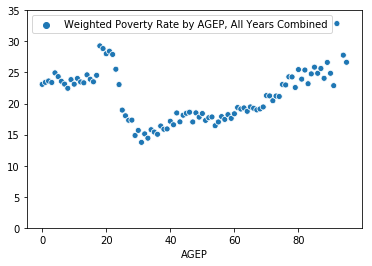

In [122]:
n = 0
scatter_combined(cats, raw_inp_vars[n])

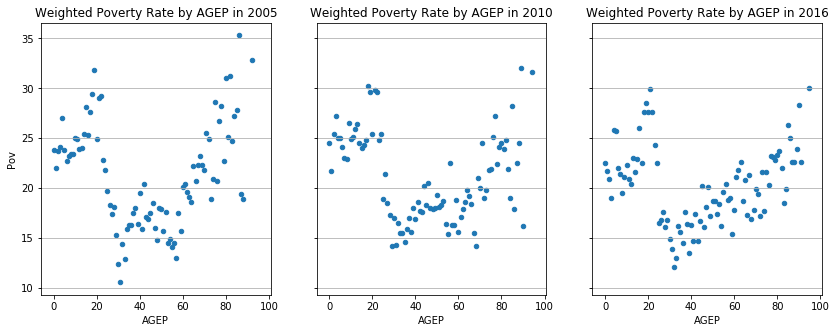

In [123]:
n = 0
scatter_sub(cats, raw_inp_vars[n])

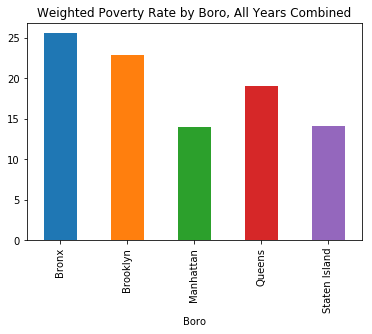

In [126]:
n = 1
bar_combined(cats, raw_inp_vars[n])

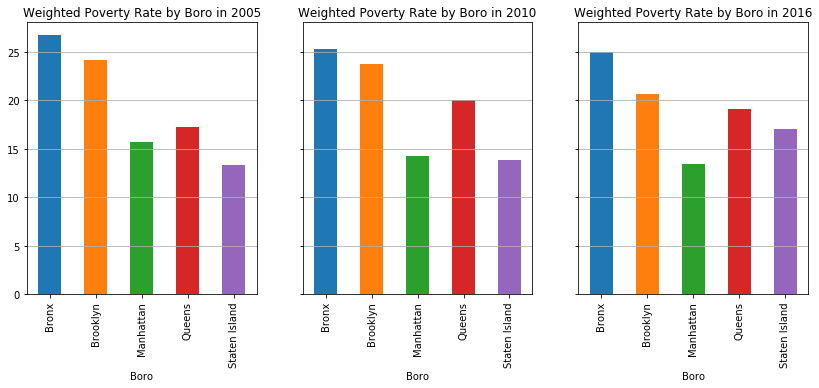

In [127]:
n = 1
bar_sub(cats, raw_inp_vars[n])

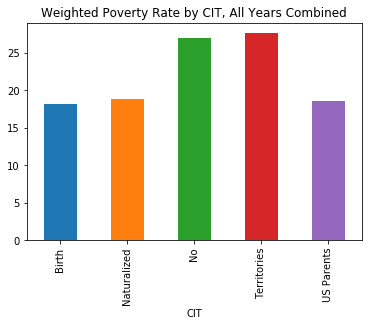

In [128]:
n = 2
bar_combined(cats, raw_inp_vars[n])

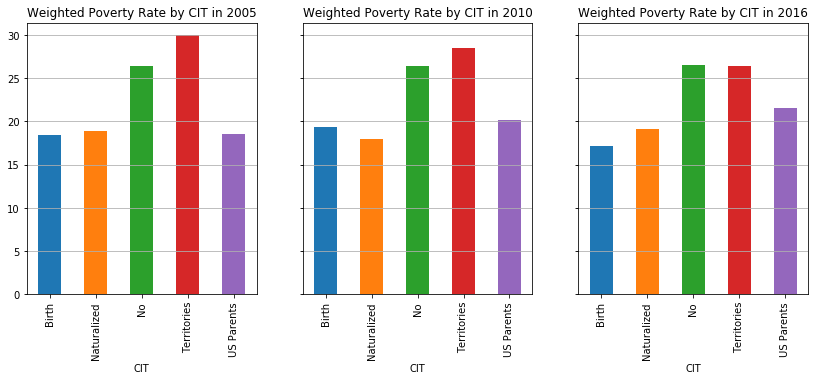

In [129]:
n = 2
bar_sub(cats, raw_inp_vars[n])

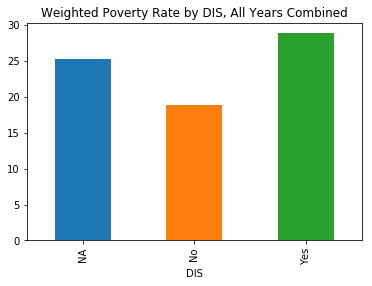

In [130]:
n = 3
bar_combined(cats, raw_inp_vars[n])

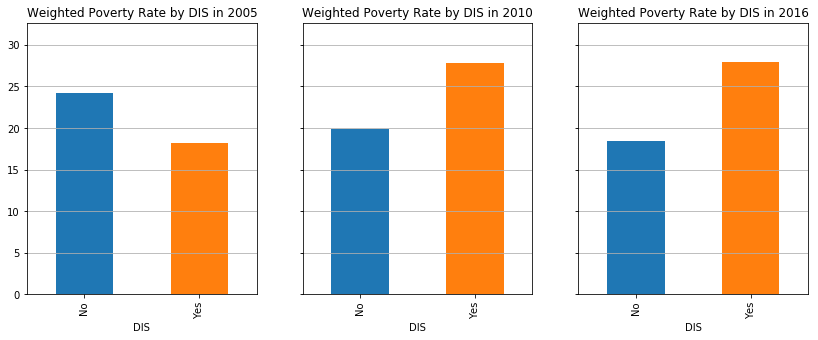

In [131]:
n = 3
bar_sub(cats, raw_inp_vars[n])

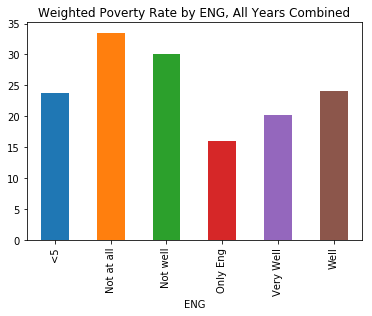

In [132]:
n = 4
bar_combined(cats, raw_inp_vars[n])

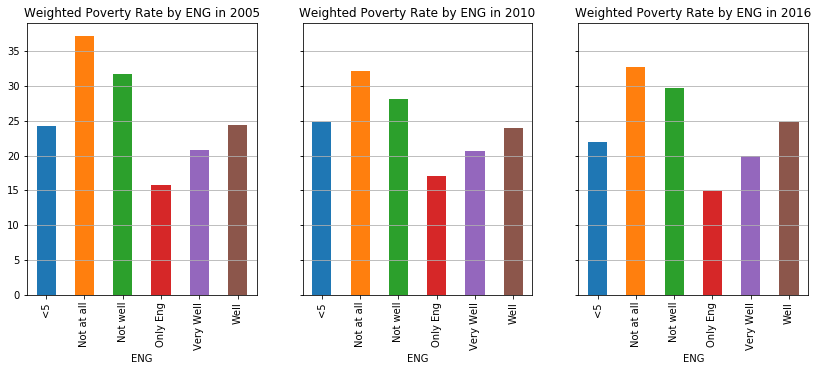

In [133]:
n = 4
bar_sub(cats, raw_inp_vars[n])

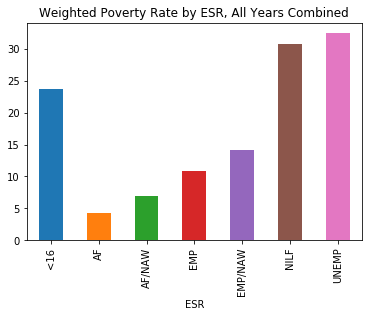

In [134]:
n = 5
bar_combined(cats, raw_inp_vars[n])

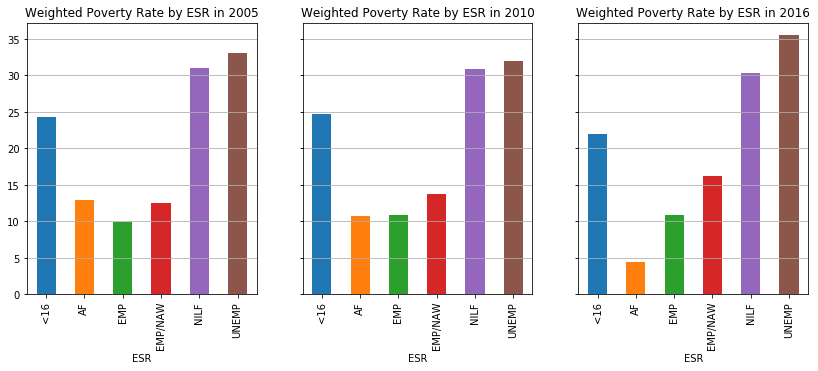

In [135]:
n = 5
bar_sub(cats, raw_inp_vars[n])

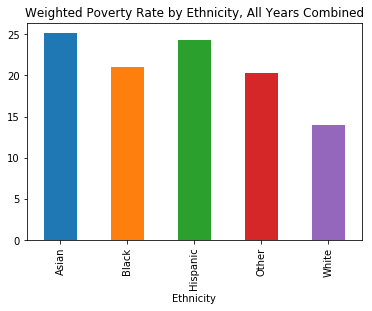

In [136]:
n = 6
bar_combined(cats, raw_inp_vars[n])

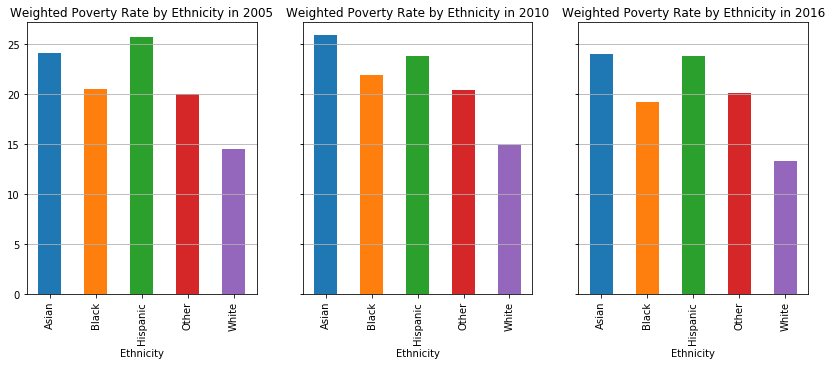

In [137]:
n = 6
bar_sub(cats, raw_inp_vars[n])

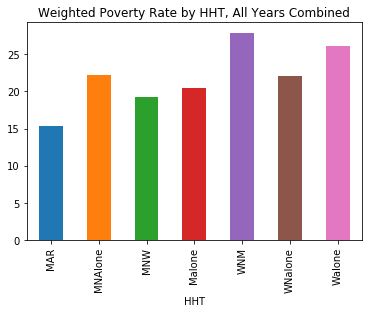

In [138]:
n = 7
bar_combined(cats, raw_inp_vars[n])

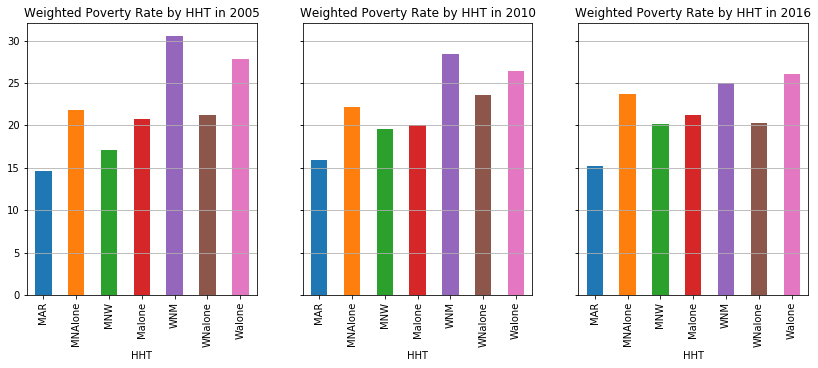

In [139]:
n = 7
bar_sub(cats, raw_inp_vars[n])

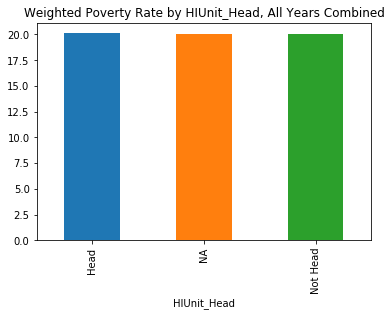

In [140]:
n = 8
bar_combined(cats, raw_inp_vars[n])

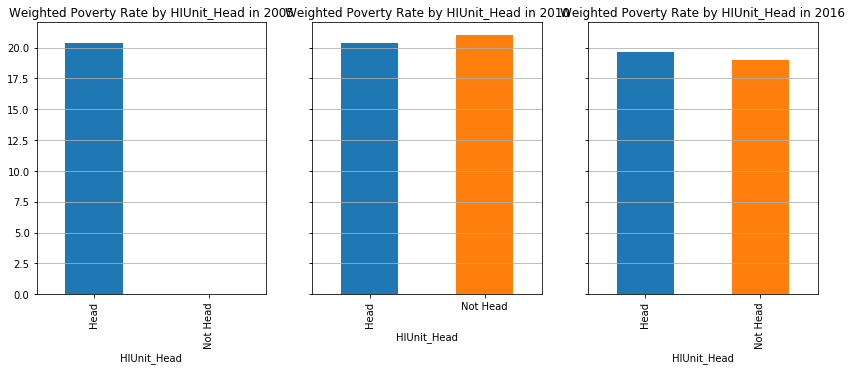

In [141]:
n = 8
bar_sub(cats, raw_inp_vars[n])

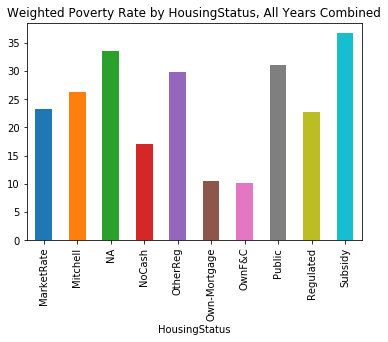

In [142]:
n = 9
bar_combined(cats, raw_inp_vars[n])

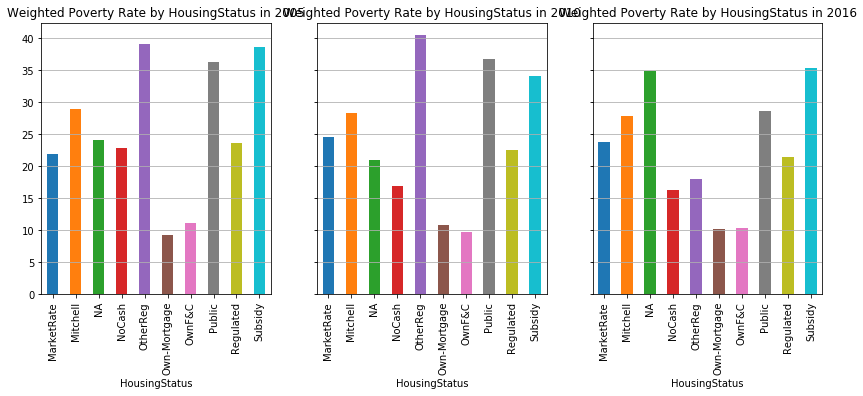

In [143]:
n = 9
bar_sub(cats, raw_inp_vars[n])

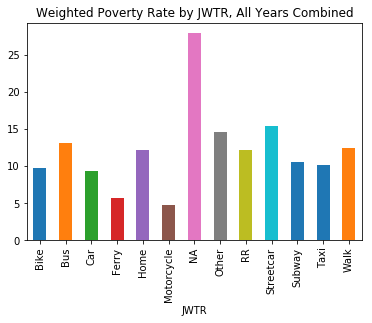

In [144]:
n = 10
bar_combined(cats, raw_inp_vars[n])

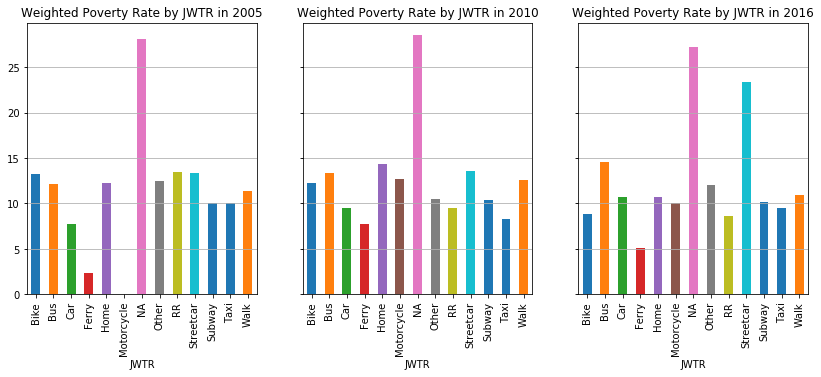

In [145]:
n = 10
bar_sub(cats, raw_inp_vars[n])

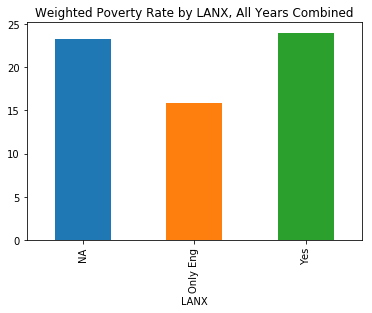

In [146]:
n = 11
bar_combined(cats, raw_inp_vars[n])

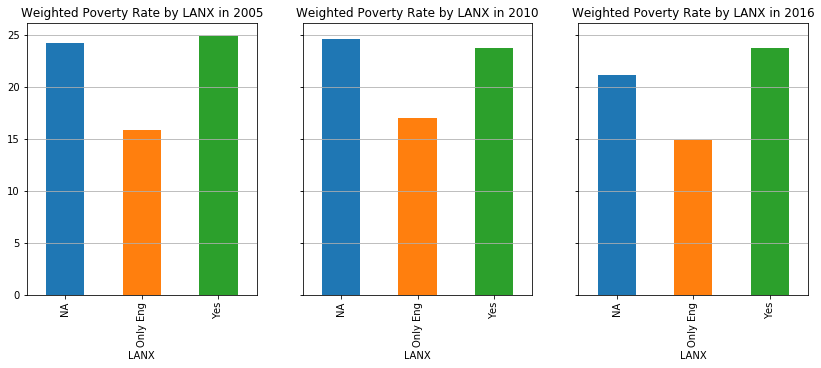

In [147]:
n = 11
bar_sub(cats, raw_inp_vars[n])

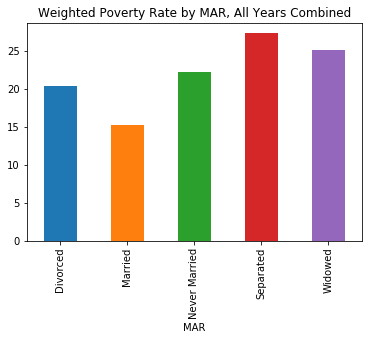

In [148]:
n = 12
bar_combined(cats, raw_inp_vars[n])

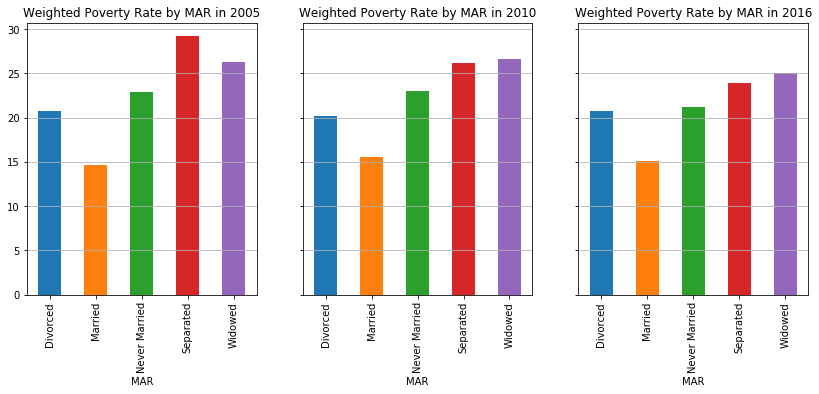

In [149]:
n = 12
bar_sub(cats, raw_inp_vars[n])

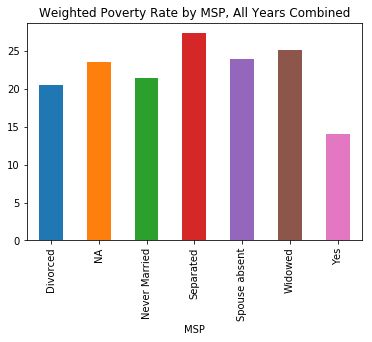

In [150]:
n = 13
bar_combined(cats, raw_inp_vars[n])

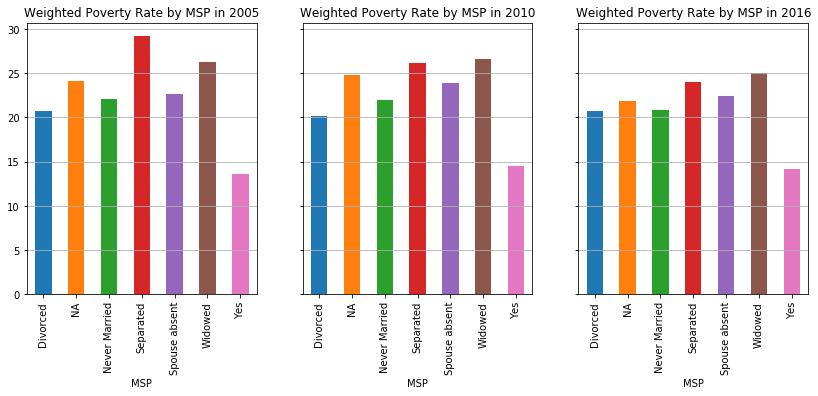

In [151]:
n = 13
bar_sub(cats, raw_inp_vars[n])

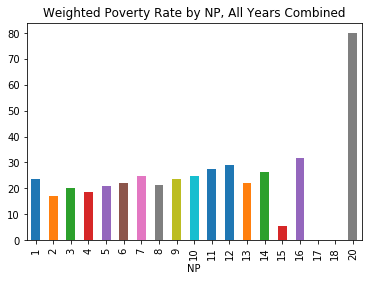

In [152]:
n = 14
bar_combined(cats, raw_inp_vars[n])

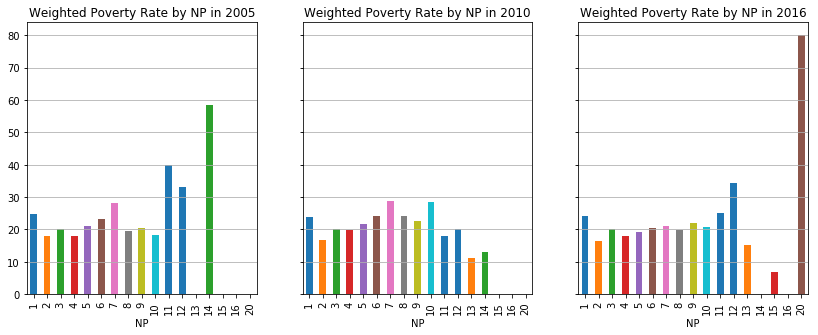

In [153]:
n = 14
bar_sub(cats, raw_inp_vars[n])

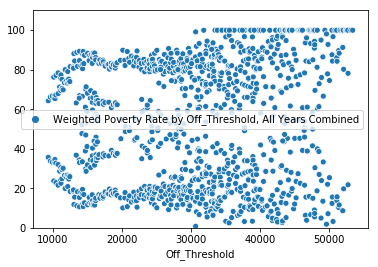

In [158]:
n = 15
scatter_combined(cats, raw_inp_vars[n], 110)

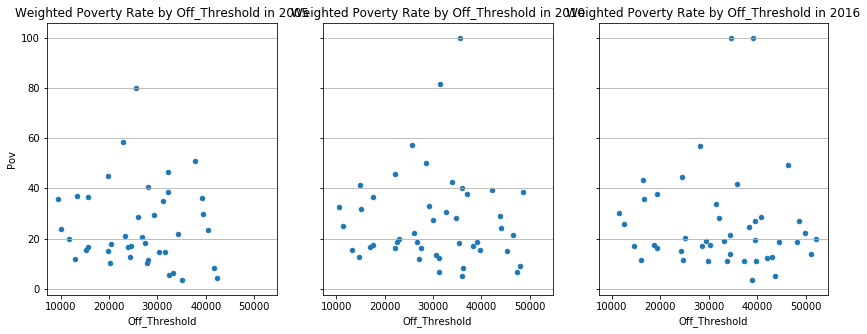

In [161]:
n = 15
scatter_sub(cats, raw_inp_vars[n])

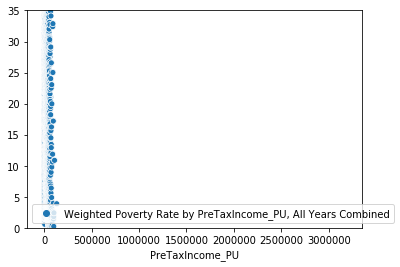

In [162]:
n = 16
scatter_combined(cats, raw_inp_vars[n])

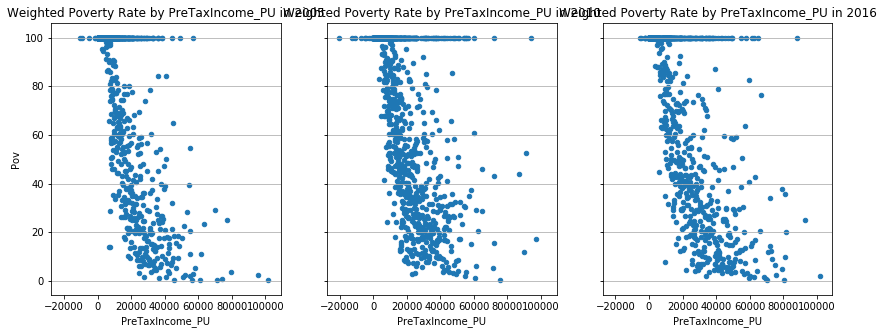

In [163]:
n = 16
scatter_sub(cats, raw_inp_vars[n])

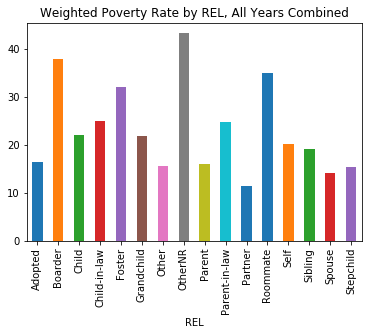

In [165]:
n = 17
bar_combined(cats, raw_inp_vars[n])

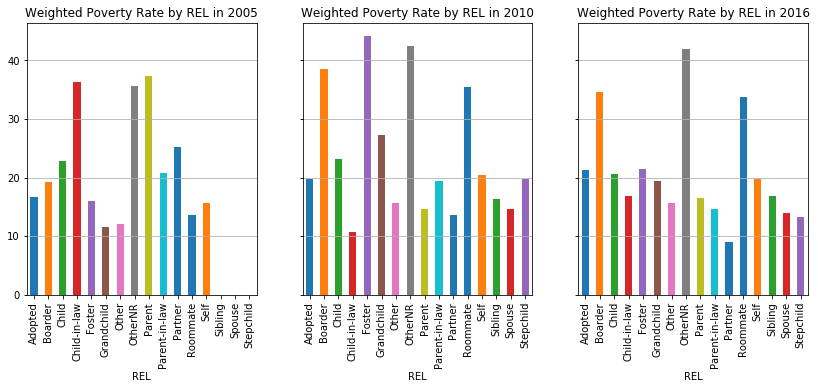

In [166]:
n = 17
bar_sub(cats, raw_inp_vars[n])

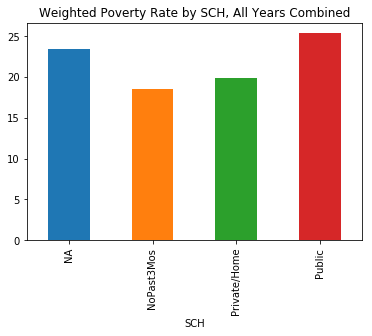

In [167]:
n = 18
bar_combined(cats, raw_inp_vars[n])

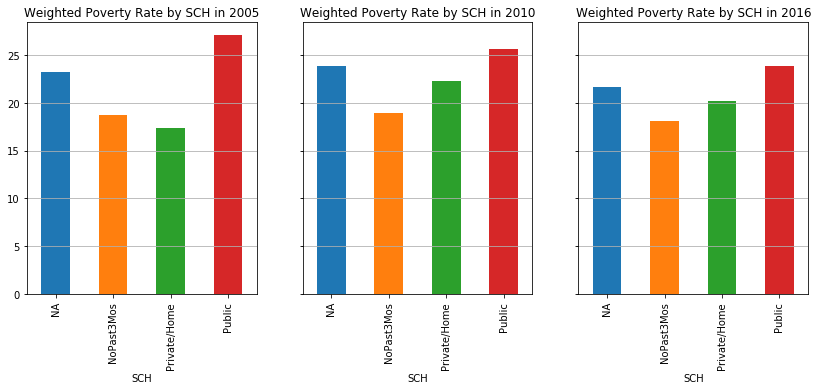

In [168]:
n = 18
bar_sub(cats, raw_inp_vars[n])

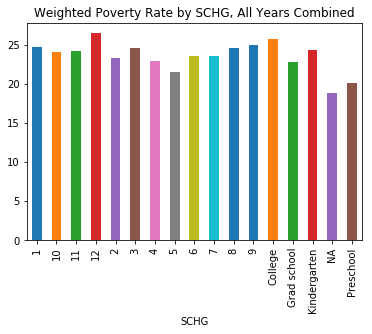

In [169]:
n = 19
bar_combined(cats, raw_inp_vars[n])

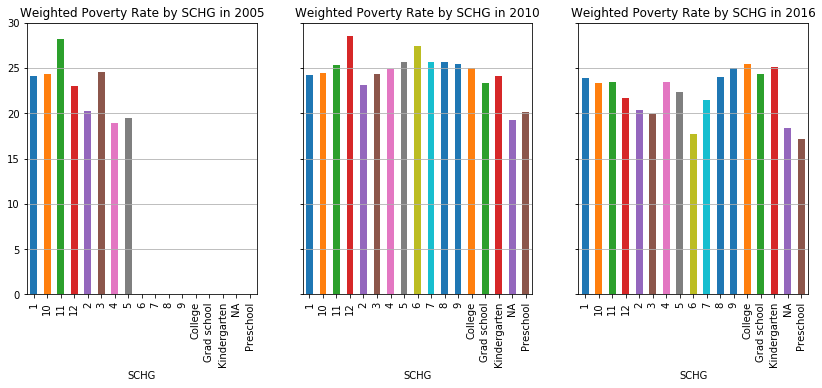

In [170]:
n = 19
bar_sub(cats, raw_inp_vars[n])

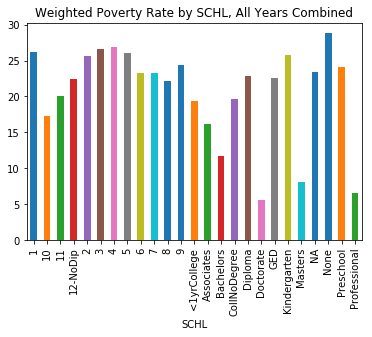

In [171]:
n = 20
bar_combined(cats, raw_inp_vars[n])

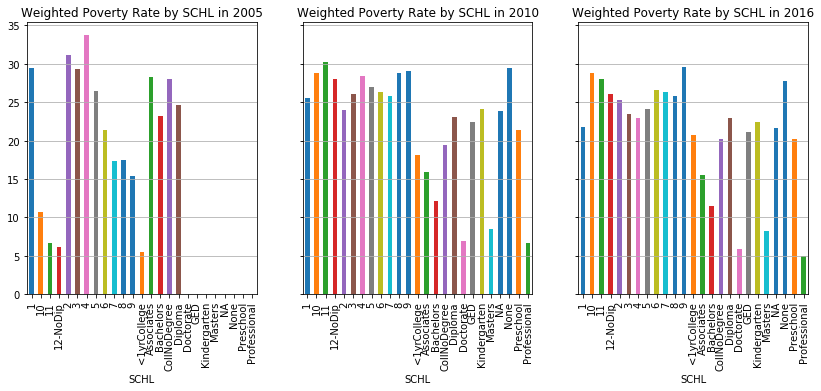

In [172]:
n = 20
bar_sub(cats, raw_inp_vars[n])

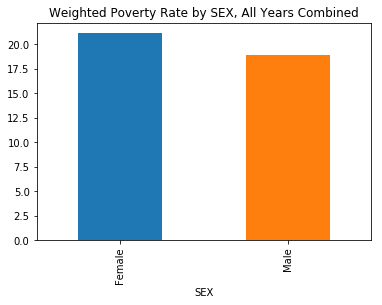

In [173]:
n = 21
bar_combined(cats, raw_inp_vars[n])

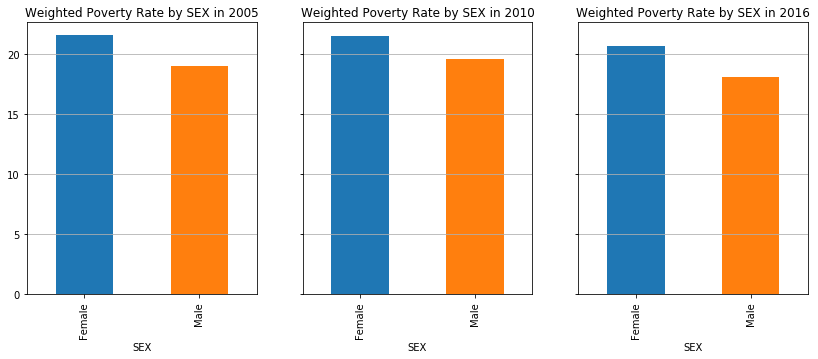

In [174]:
n = 21
bar_sub(cats, raw_inp_vars[n])

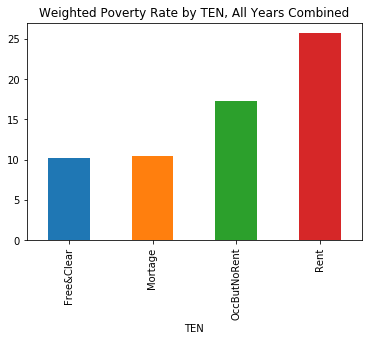

In [175]:
n = 22
bar_combined(cats, raw_inp_vars[n])

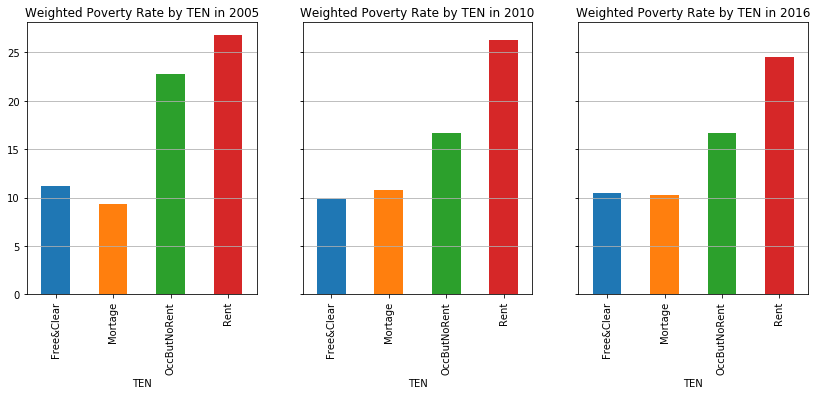

In [176]:
n = 22
bar_sub(cats, raw_inp_vars[n])

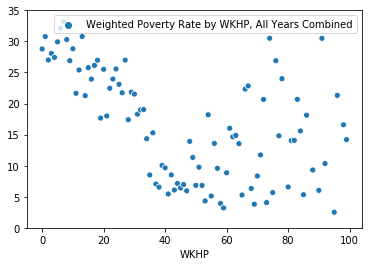

In [178]:
n = 23
scatter_combined(cats, raw_inp_vars[n])

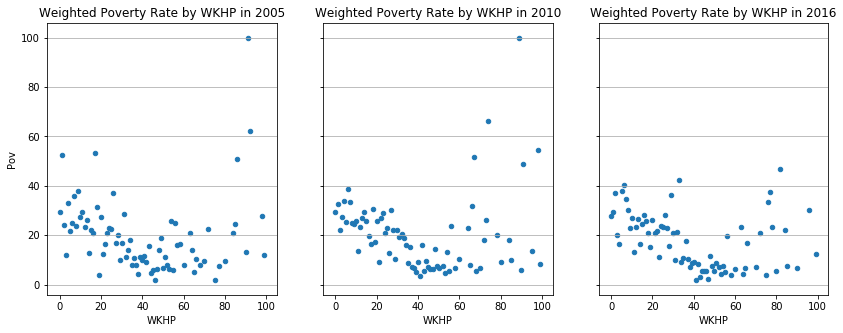

In [179]:
n = 23
scatter_sub(cats, raw_inp_vars[n])

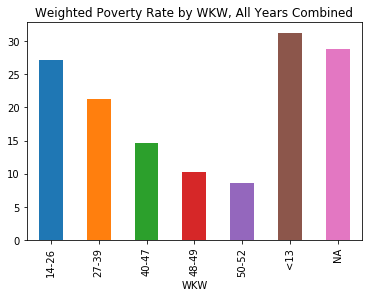

In [180]:
n = 24
bar_combined(cats, raw_inp_vars[n])

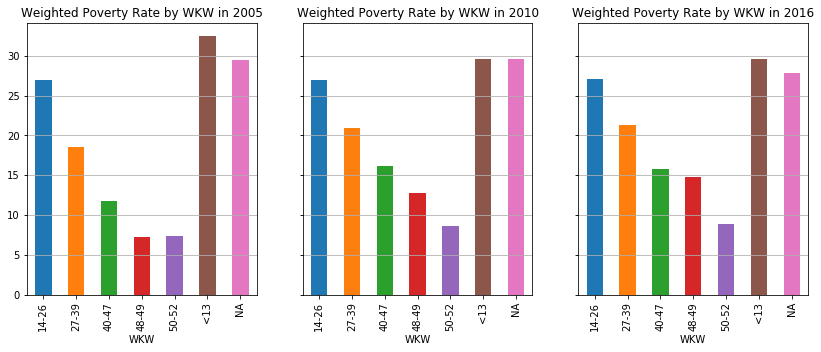

In [185]:
n = 24
bar_sub(cats, raw_inp_vars[n])

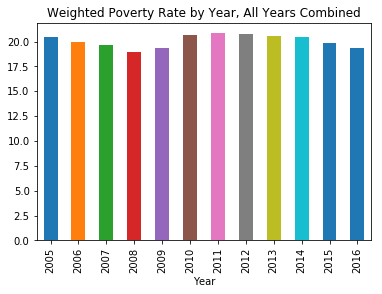

In [182]:
n = 25
bar_combined(cats, raw_inp_vars[n])

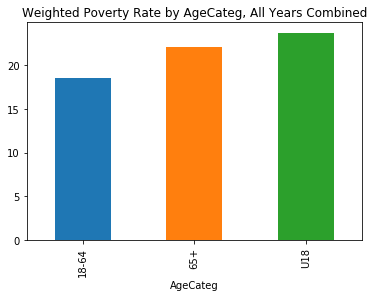

In [189]:
n = 0
bar_combined(cats, acs_vars[n])

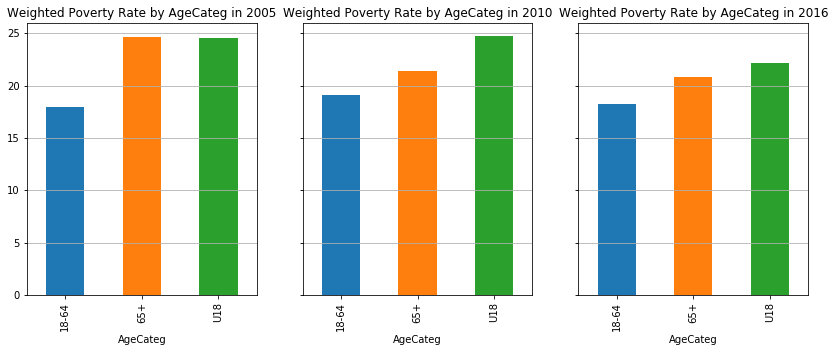

In [190]:
n = 0
bar_sub(cats, acs_vars[n])

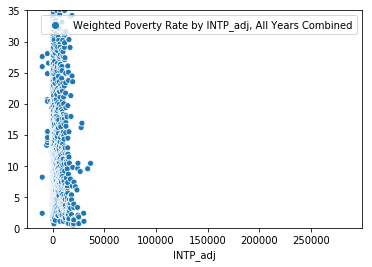

In [191]:
n = 1
scatter_combined(cats, acs_vars[n])

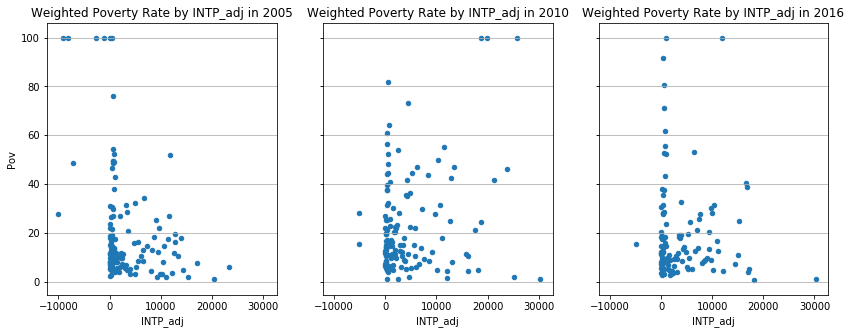

In [192]:
n = 1
scatter_sub(cats, acs_vars[n])

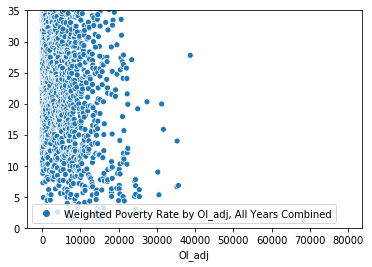

In [193]:
n = 2
scatter_combined(cats, acs_vars[n])

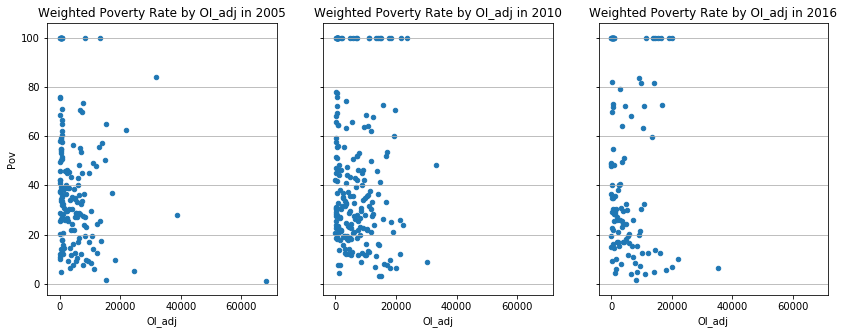

In [194]:
n = 2
scatter_sub(cats, acs_vars[n])

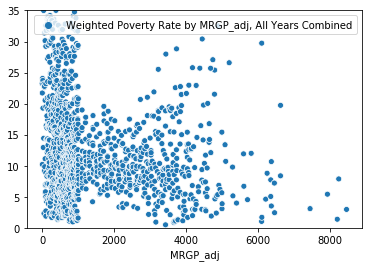

In [195]:
n = 3
scatter_combined(cats, acs_vars[n])

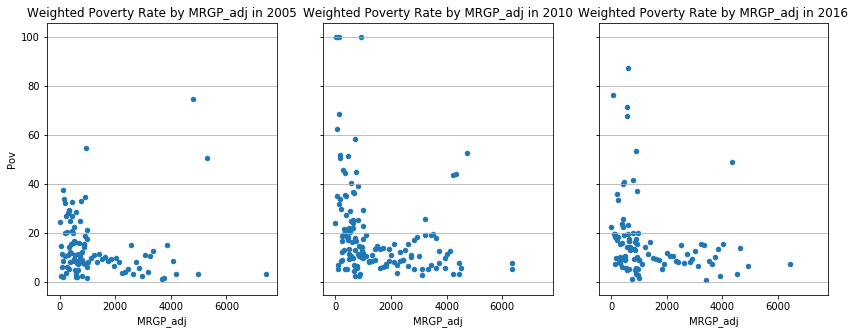

In [196]:
n = 3
scatter_sub(cats, acs_vars[n])

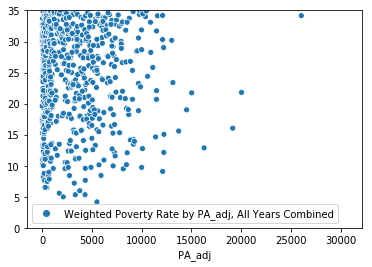

In [197]:
n = 4
scatter_combined(cats, acs_vars[n])

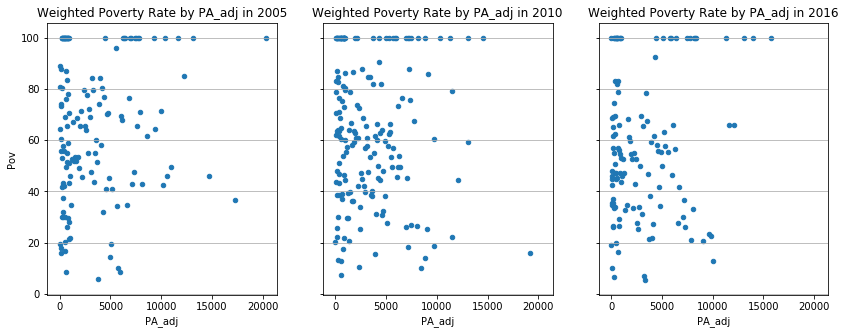

In [199]:
n = 4
scatter_sub(cats, acs_vars[n])

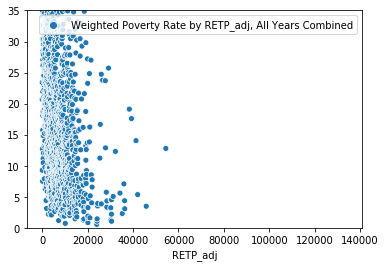

In [200]:
n = 5
scatter_combined(cats, acs_vars[n])

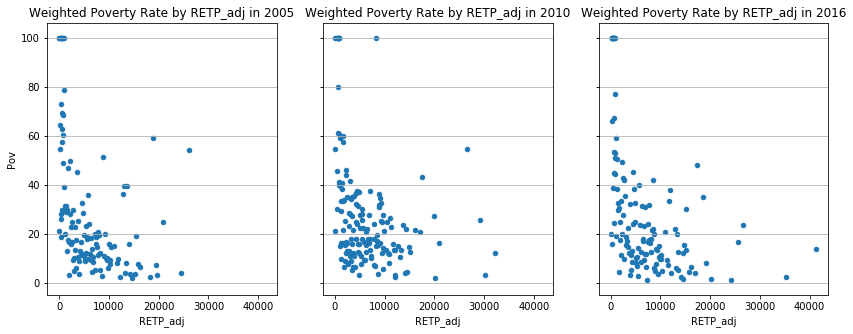

In [201]:
n = 5
scatter_sub(cats, acs_vars[n])

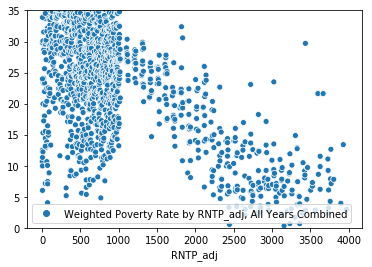

In [202]:
n = 6
scatter_combined(cats, acs_vars[n])

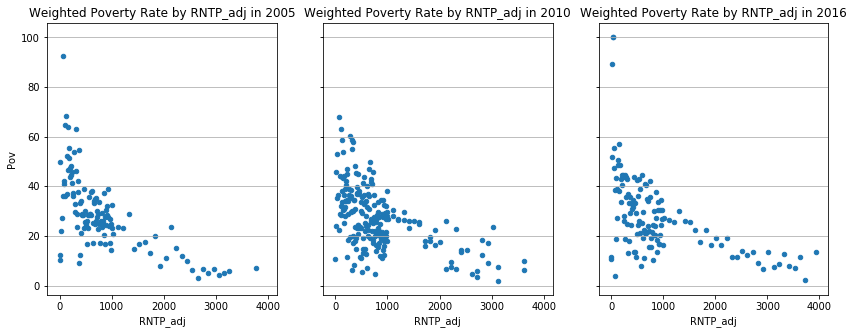

In [203]:
n = 6
scatter_sub(cats, acs_vars[n])

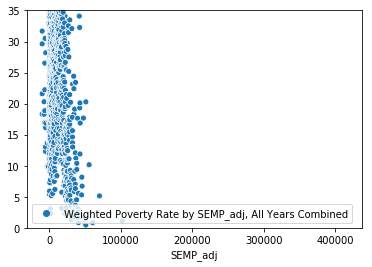

In [204]:
n = 7
scatter_combined(cats, acs_vars[n])

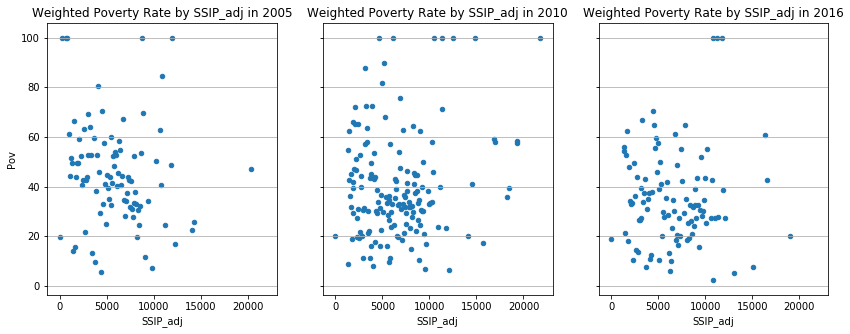

In [205]:
n = 8
scatter_sub(cats, acs_vars[n])

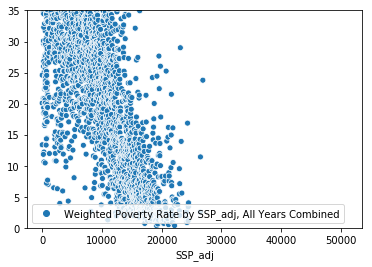

In [206]:
n = 9
scatter_combined(cats, acs_vars[n])

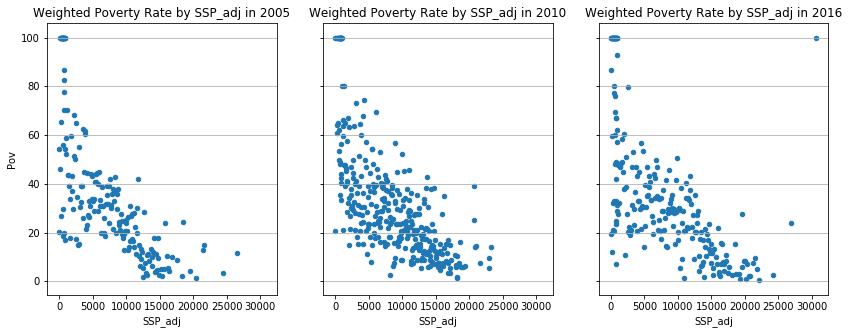

In [207]:
n = 9
scatter_sub(cats, acs_vars[n])

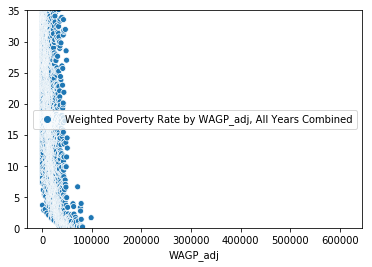

In [208]:
n = 10
scatter_combined(cats, acs_vars[n])

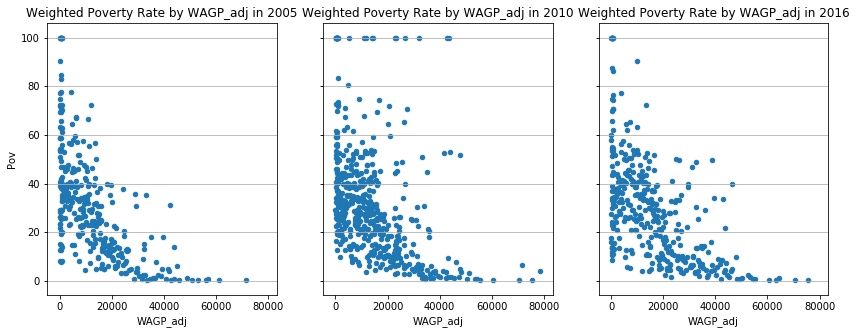

In [209]:
n = 10
scatter_sub(cats, acs_vars[n])

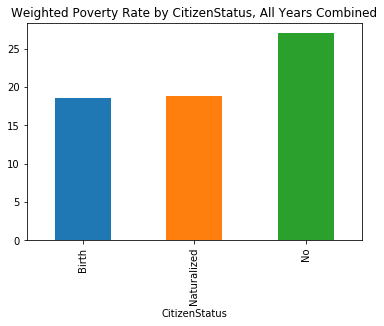

In [212]:
n = 0
bar_combined(cats, nyc_vars[n])

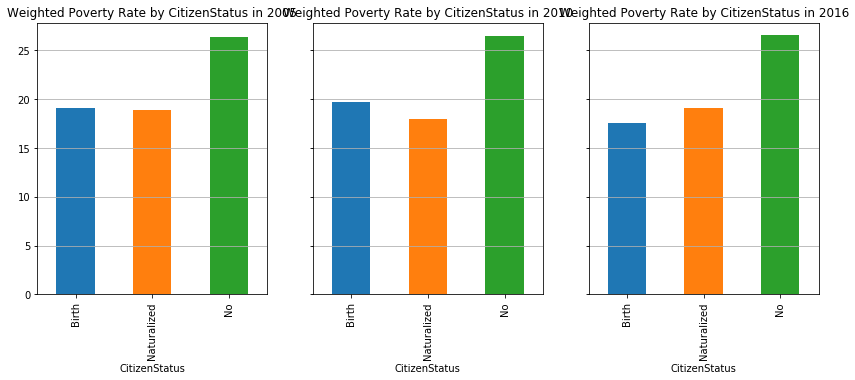

In [213]:
n = 0
bar_sub(cats, nyc_vars[n])

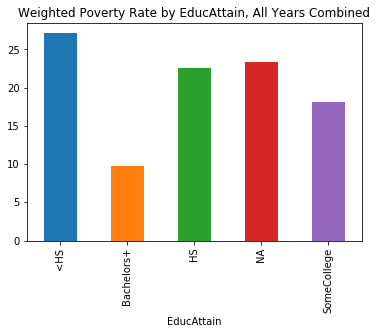

In [214]:
n = 1
bar_combined(cats, nyc_vars[n])

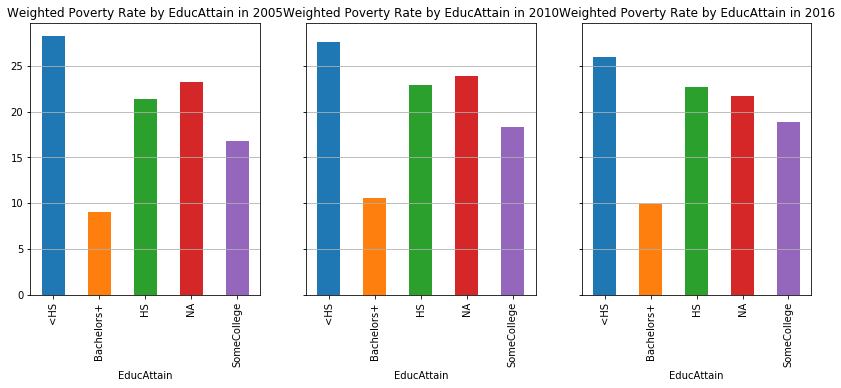

In [215]:
n = 1
bar_sub(cats, nyc_vars[n])

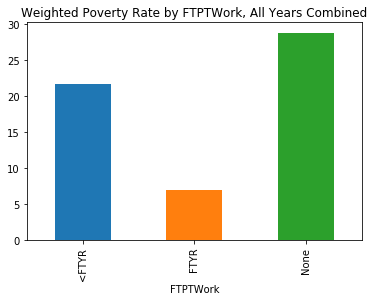

In [216]:
n = 2
bar_combined(cats, nyc_vars[n])

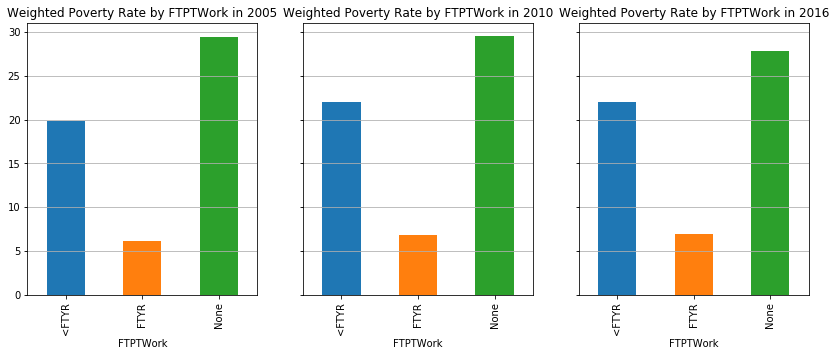

In [217]:
n = 2
bar_sub(cats, nyc_vars[n])

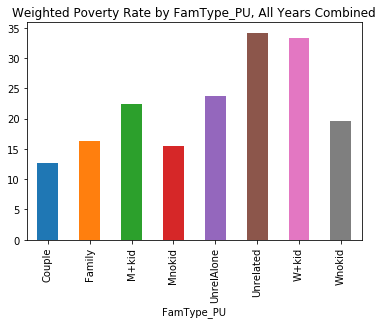

In [218]:
n = 3
bar_combined(cats, nyc_vars[n])

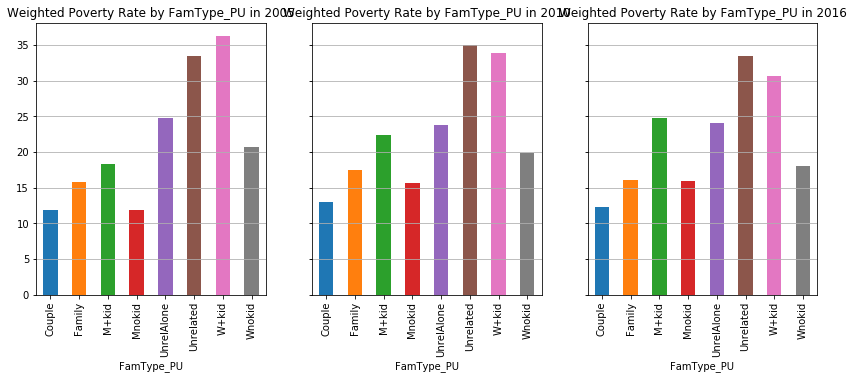

In [219]:
n = 3
bar_sub(cats, nyc_vars[n])

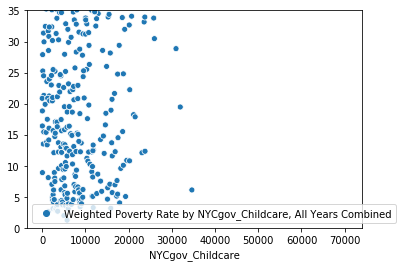

In [13]:
n = 4
scatter_combined(cats, nyc_vars[n])

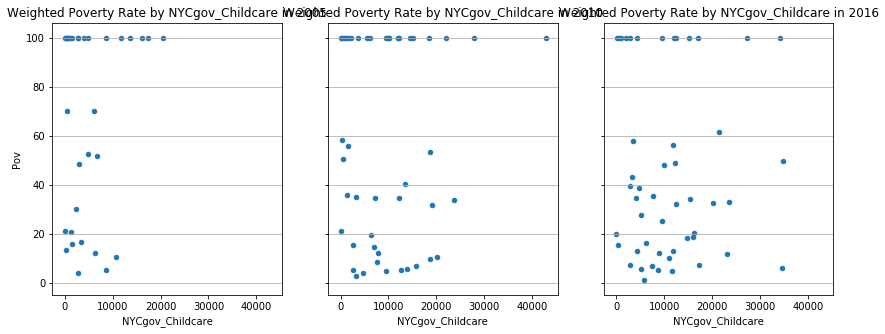

In [15]:
n = 4
scatter_sub(cats, nyc_vars[n])

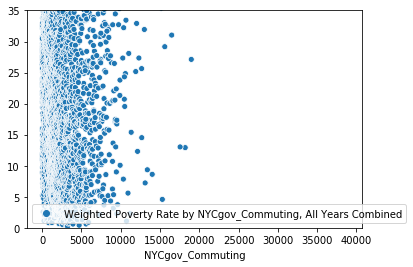

In [16]:
n = 5
scatter_combined(cats, nyc_vars[n])

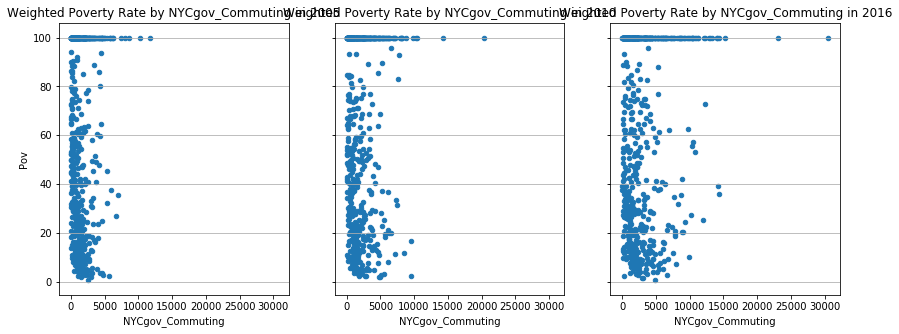

In [17]:
n = 5
scatter_sub(cats, nyc_vars[n])

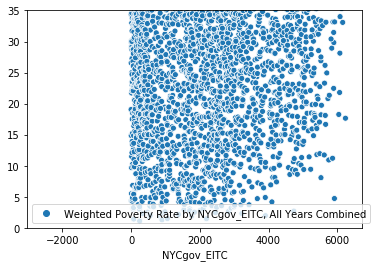

In [18]:
n = 6
scatter_combined(cats, nyc_vars[n])

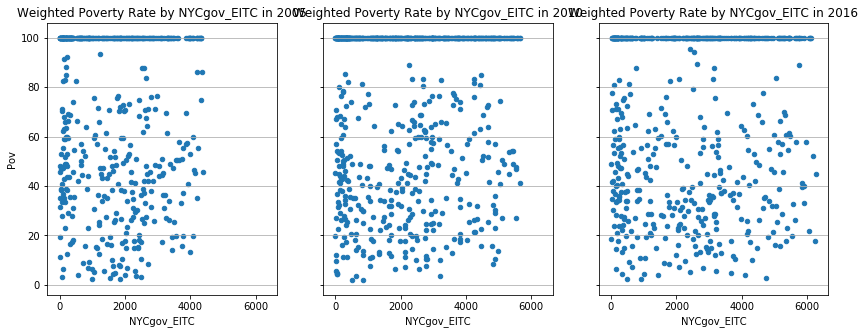

In [19]:
n = 6
scatter_sub(cats, nyc_vars[n])

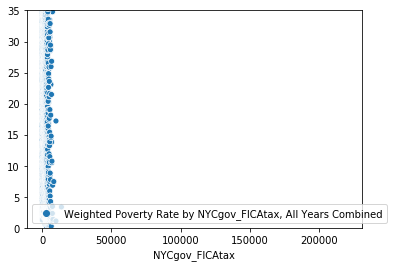

In [20]:
n = 7
scatter_combined(cats, nyc_vars[n])

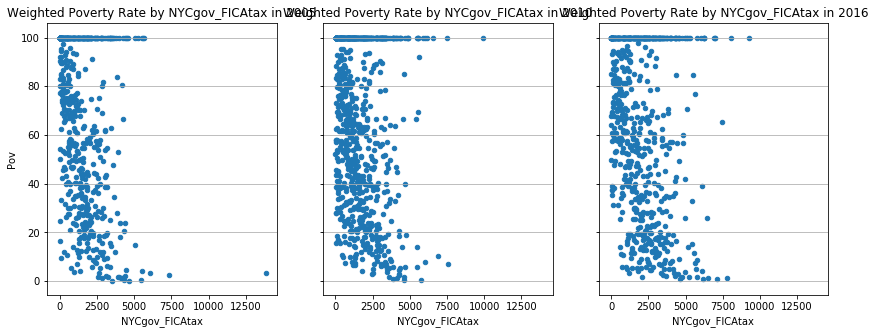

In [21]:
n = 7
scatter_sub(cats, nyc_vars[n])

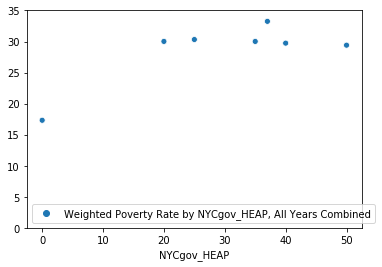

In [22]:
n = 8
scatter_combined(cats, nyc_vars[n])

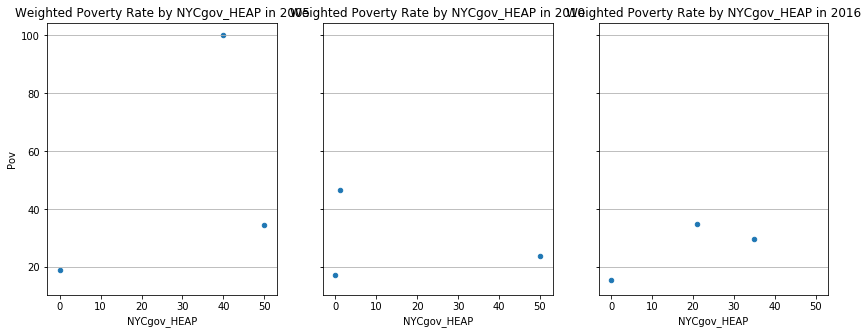

In [23]:
n = 8
scatter_sub(cats, nyc_vars[n])

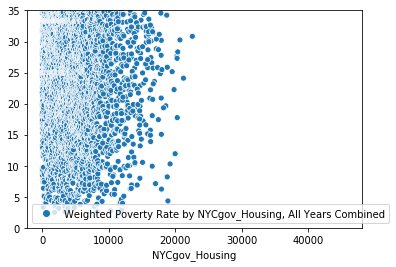

In [24]:
n = 9
scatter_combined(cats, nyc_vars[n])

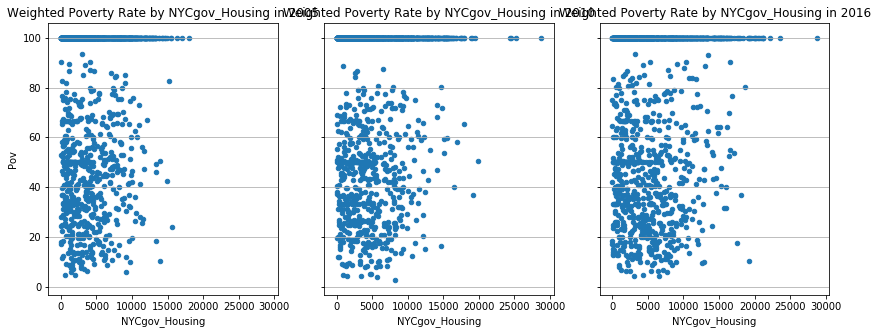

In [25]:
n = 9
scatter_sub(cats, nyc_vars[n])

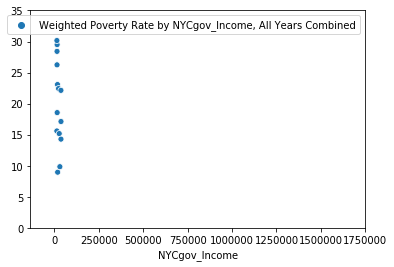

In [26]:
n = 10
scatter_combined(cats, nyc_vars[n])

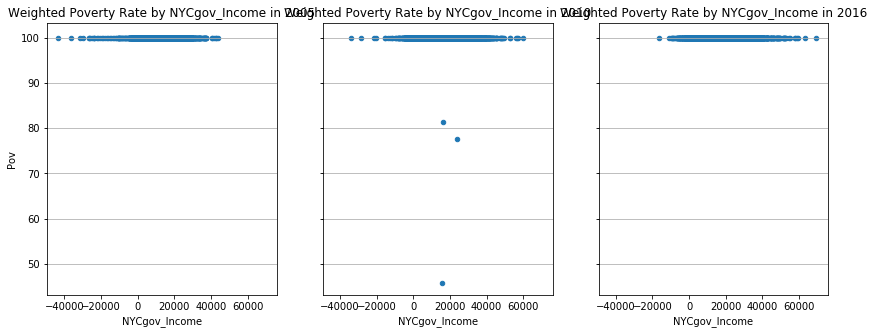

In [27]:
n = 10
scatter_sub(cats, nyc_vars[n])

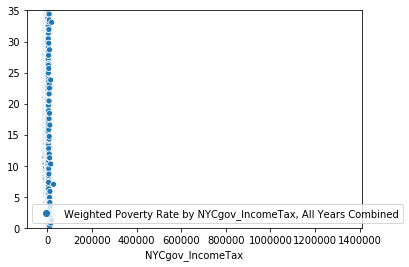

In [28]:
n = 11
scatter_combined(cats, nyc_vars[n])

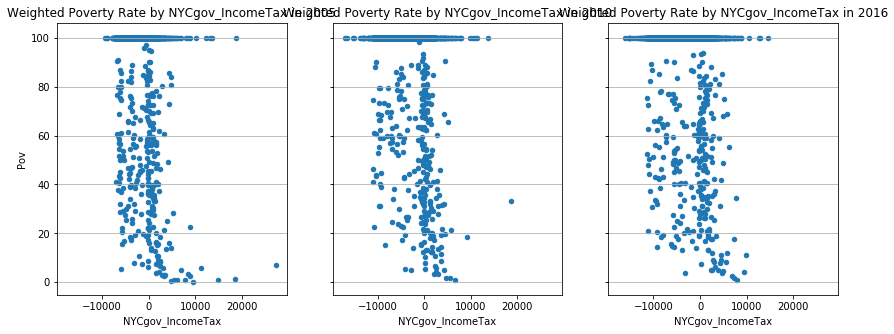

In [29]:
n = 11
scatter_sub(cats, nyc_vars[n])

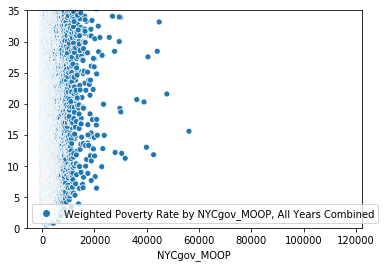

In [30]:
n = 12
scatter_combined(cats, nyc_vars[n])

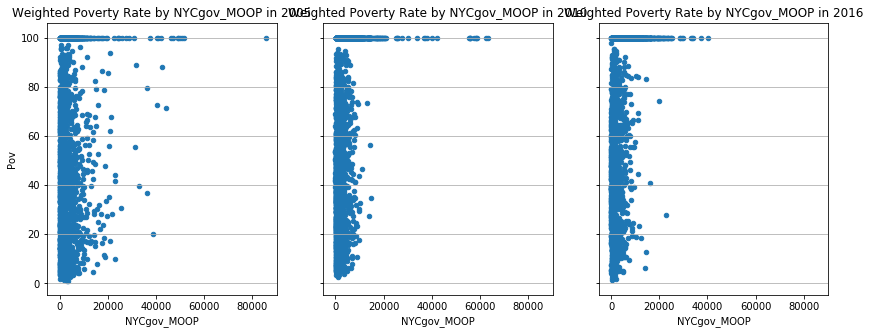

In [31]:
n = 12
scatter_sub(cats, nyc_vars[n])

In [45]:
#pd.crosstab(cats.PreTaxIncome_PU, cats.Boro).plot(kind='scatter', x=cats.Boro, y=cats.PreTaxIncome_PU, bins=20, figsize=(24,14))
#pd.crosstab(cats.PreTaxIncome_PU, cats.Boro).index#head(30)
cats[['PreTaxIncome_PU', 'Boro']].plot(kind='scatter', y='Boro', x='PreTaxIncome_PU', bins=20)

ValueError: scatter requires y column to be numeric

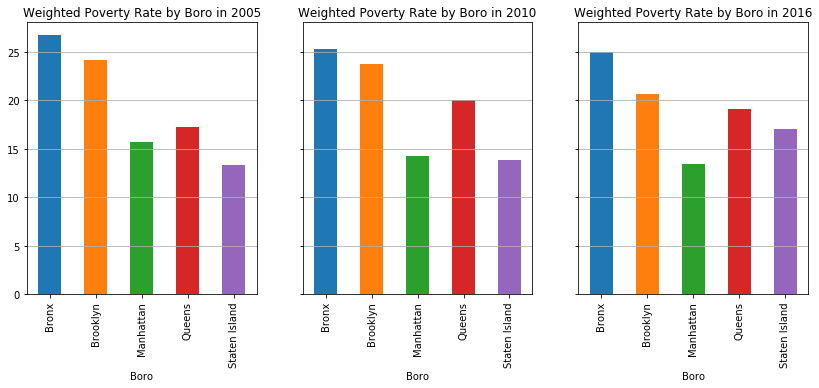

In [119]:
n = 1
bar_sub(cats, raw_inp_vars[n])

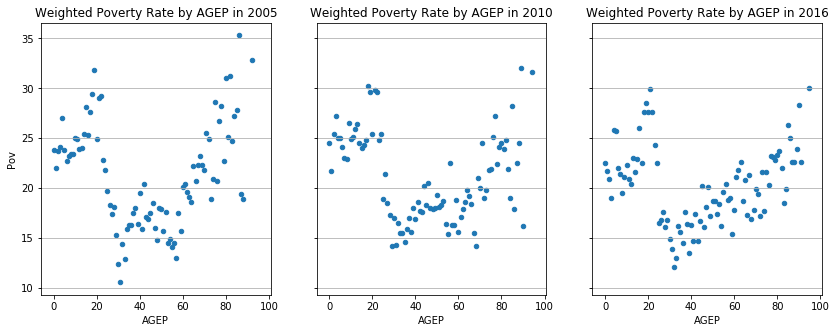

In [95]:
# Show a few charts by individual years:

# Set up initial variables
n = 0
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'

# Create a dataframe including years, target column, and weights
focus_df = cats[['NYCgov_Pov_Stat', 'Year', labels[n], weight]]

# Create the charts
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
for year, axis in zip([2005, 2010, 2016], range(3)):
    tester = pd.DataFrame(df_for_pov_chart(focus_df.loc[focus_df.Year == year], labels[n], weight)).reset_index()
    ax = tester.plot(kind='scatter', x='AGEP', y='Pov', title = 'Weighted Poverty Rate by ' + labels[n] + ' in ' + str(year), ax=axes[axis])
    ax.grid(which='major', axis='y')

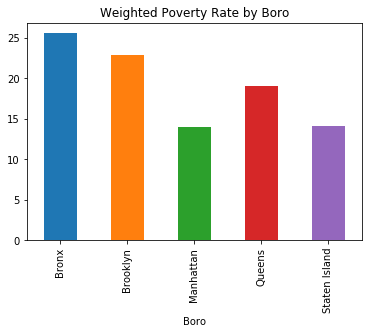

In [96]:
# Create a chart by all years combined for basic overview:

# Set up initial variables
n = 1
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'

# Since this column only has a few categories, we can create our chart right away
df_for_pov_chart(cats, 'Boro', weight).plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

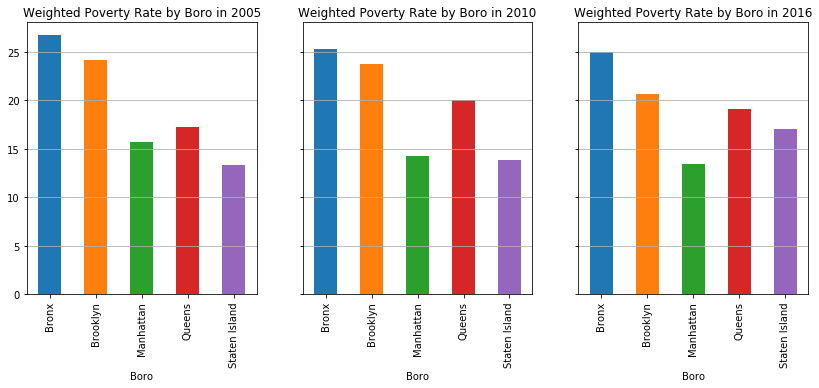

In [97]:
# Show a few charts by individual years:

# Set up initial variables
n = 1
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'

# Create a dataframe including years, target column, and weights
focus_df = cats[['NYCgov_Pov_Stat', 'Year', labels[n], weight]]

# Create the charts
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
for year, axis in zip([2005, 2010, 2016], range(3)):
    ax = df_for_pov_chart(focus_df.loc[focus_df.Year == year], labels[n], weight).plot(kind='bar', title = 'Weighted Poverty Rate by ' + labels[n] + ' in ' + str(year), ax=axes[axis])
    ax.grid(which='major', axis='y')

In [30]:
n = 1
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight, 'Year']].groupby([labels[n], 'NYCgov_Pov_Stat', 'Year']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
#pcts = pcts.unstack('Year')
#pcts[weight]['Pov'].plot(kind='bar', legend=None, title='Weighted Poverty Rate by ' + str(labels[n]))
pcts
#pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro).plot(kind='pie', subplots=True, figsize=(24,14))
#pd.crosstab(pcts[weight].Pov, pcts.Year)

WGTP          
NYCgov_Pov_Stat      Not Pov       Pov
Boro          Year                    
Bronx         2005  6.010486  2.190246
              2006  6.077449  2.070853
              2007  6.154909  1.992746
              2008  6.062890  2.099528
              2009  6.235090  2.043155
              2010  6.223953  2.105764
              2011  6.154817  2.006532
              2012  6.150444  2.131322
              2013  6.325768  2.109992
              2014  6.211356  2.240899
              2015  6.284185  2.383393
              2016  6.555135  2.179089
Brooklyn      2005  6.029506  1.923445
              2006  5.969570  1.954426
              2007  6.053471  1.964808
              2008  6.224137  1.821819
              2009  6.359574  1.917050
              2010  6.430199  2.008245
              2011  6.337961  1.954196
              2012  6.566981  1.898731
              2013  6.684577  1.904350
              2014  6.786507  1.873212
              2015  6.817372  1.831685
              2016  6.897491  1.790688
Manhattan     2005  6.895462  1.287933
              2006  7.131723  1.171758
              2007  7.025904  1.087354
              2008  7.264018  1.035611
              2009  7.359587  1.058058
              2010  7.163699  1.193947
              2011  7.026889  1.216335
              2012  7.040974  1.167999
              2013  6.895416  1.203235
              2014  7.517964  1.240395
              2015  7.206916  1.174280
              2016  7.477955  1.156588
Queens        2005  6.787714  1.411560
              2006  6.900656  1.429630
              2007  6.859999  1.474830
              2008  6.870612  1.425797
              2009  6.950840  1.479073
              2010  6.738725  1.687931
              2011  6.564095  1.728808
              2012  6.550611  1.832568
              2013  6.665702  1.767086
              2014  6.654139  1.712445
              2015  6.828169  1.558015
              2016  6.566252  1.554742
Staten Island 2005  7.227127  1.111469
              2006  7.408336  1.046039
              2007  7.525584  0.965008
              2008  7.666582  0.877368
              2009  7.265458  1.200793
              2010  7.111295  1.144318
              2011  6.930964  1.216053
              2012  7.026431  1.093432
              2013  6.916330  1.277274
              2014  6.742752  1.512826
              2015  7.138395  1.286910
              2016  6.891362  1.417896

In [ ]:
n = 2
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 3
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 4
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 5
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 6
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 7
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 8
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [ ]:
n = 1
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
weight = 'PWGTP'
counts = cats.loc[(cats.Year == 2013), ['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
#counts = cats.loc[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head'), ['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
#pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))
pcts
#cats.loc[(cats.Year == 2016) & (cats.NYCgov_Pov_Stat == 1) & (cats.Povunit_Rel == 1), ['NYCgov_Pov_Stat', labels[n], weight]]#.groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
#cats[['Year', 'NYCgov_Pov_Stat', 'Povunit_Rel']]
#cats.loc[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head')]#(cats.NYCgov_Pov_Stat == 'Pov') & (cats.Povunit_Rel == 'Head')]#,['NYCgov_Pov_Stat', labels[n], weight]]#.groupby([labels[n], 'NYCgov_Pov_Stat']).sum()

In [ ]:
'PWGTP' if labels[n] in per_vars else 'WGTP'

In [ ]:
#t2016 = pd.read_csv('data/NYCgov_Poverty_Measure_Data__2016_.csv')
#t2016.head()
t2013 = pd.read_csv('data/NYCgov_Poverty_Measure_Data__2013_.csv')
t2013.head()
#cleaned_2013 = df.loc[df.Year == 2013, 'SERIALNO'].unique()
#all_2013= t2013['SERIALNO'].unique()
#all_2013 - cleaned_2013
#t2013.loc[~t2013.SERIALNO.isin(df.loc[df.Year == 2013].SERIALNO), ['PWGTP', 'NYCgov_Pov_Stat', 'Boro']]
#removed = t2013.loc[~t2013.SERIALNO.isin(df.loc[df.Year == 2013].SERIALNO)]
#r_list = removed.columns[removed.isna().any()].tolist()
#r_list.sort()

#len(t2013)

# Create a copy for comparison later, then do initial cleanup
t2013_orig = t2013.copy()
    
# Create temporary column 'FivePlus' to make it easier to distribute the ENG NaNs appropriately
t2013['FivePlus'] = t2013.AGEP >= 5

# Change the rows where ENG is null and over age five to be 5 (they only speak English)
# Change the rows where ENG is null and under age five to be 0 
t2013.loc[((t2013.ENG.isnull()) & (t2013.FivePlus == True)), 'ENG'] = 5
t2013.loc[((t2013.ENG.isnull()) & (t2013.FivePlus == False)), 'ENG'] = 0

# Remove the temporary column created above
t2013.drop('FivePlus', axis=1, inplace=True)
   
# Change null values to zeros where the person is under age or the question doesn't make sense for that person
# (e.g. a five-year-old is neither married nor unmarried, they're just a five-year-old)
t2013.loc[t2013.JWTR.isnull(), 'JWTR'] = 0
t2013.loc[t2013.WKW.isnull(), 'WKW'] = 0
t2013.loc[t2013.ESR.isnull(), 'ESR'] = 0
t2013.loc[t2013.MSP.isnull(), 'MSP'] = 0
t2013.loc[t2013.LANX.isnull(), 'LANX'] = 0
t2013.loc[t2013.EducAttain.isnull(), 'EducAttain'] = 0
t2013.loc[t2013.SCHL.isnull(), 'SCHL'] = 0
if 'DS' in t2013.columns:
    t2013.loc[t2013.DS.isnull(), 'DS'] = 0
    
# Compare nulls between the original and new datasets
check = t2013 - t2013_orig
check1 = check.ne(0).sum()
check1 = check1[check1 > 0].sort_values(ascending=False)
t2013_orig_nulls = t2013_orig.isnull().sum()
t2013_orig_nulls = t2013_orig_nulls[t2013_orig_nulls > 0].sort_values(ascending=False)
print('Number of changes by column equals original columns: \n' + str(t2013_orig_nulls == check1) + '\n')
    
# Drop any remaining rows with any NaNs and check we haven't dropped too many
mask = t2013.isna().any(1)
t2013[mask]
#mask
mask2016 = t2016.isna().any(1)
t2016[mask2016]

In [ ]:
weight = 'PWGTP'
counts = t2016[['NYCgov_Pov_Stat', 'Ethnicity', weight]].groupby(['Ethnicity', 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts

In [ ]:
#t2016.subtract(df.loc[df.Year == 2016])
#df.loc[df.Year == 2016]
new = df.loc[df.Year == 2016]
del new['Year']
t2016.subtract(new).notnull()
#new
t2016.loc[(t2016.NYCgov_Income < -50000) | (t2016.Off_Threshold.isna()), ['PWGTP', 'NYCgov_Pov_Stat', 'Boro']]

In [ ]:
pd.crosstab(cats.Boro, cats.NYCgov_Pov_Stat).plot(kind='bar')

In [ ]:
#pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro).plot(kind='bar')
#pd.crosstab(cats.Boro, cats.NYCgov_Pov_Stat).plot(kind='bar')

#pd.crosstab(cats.Boro, cats.NYCgov_Pov_Stat).plot(kind='pie', subplots=True)
pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro).plot(kind='pie', subplots=True, figsize=(24,14))
pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro)

In [ ]:
tot_by_boro = cats[['Boro','PWGTP', 'NYCgov_Pov_Stat']].groupby(['Boro', 'NYCgov_Pov_Stat']).sum().sum(level=0)
pcts = 100 * cats[['Boro','PWGTP', 'NYCgov_Pov_Stat']].groupby(['Boro', 'NYCgov_Pov_Stat']).sum()/tot_by_boro
pcts.unstack('Boro').plot(kind='pie', subplots=True, figsize=(24,14))
pcts

In [ ]:
nyc_corr.abs().sort_values(ascending=False)

In [ ]:
(nyc_corr - off_corr).abs().sort_values(ascending=False)

In [ ]:
raw_inp_vars
#df[['NYCgov_Pov_Stat', 'AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP', 'NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']].corr()['NYCgov_Pov_Stat'].abs().sort_values(ascending=False)
nyc_corr = df.corr()['NYCgov_Pov_Stat']
off_corr = df.corr()['Off_Pov_Stat']
(nyc_corr - off_corr).sort_values(ascending=False)

In [ ]:
sns.jointplot(x='Boro', y='NYCgov_Pov_Stat', data=cats[['Boro', 'NYCgov_Pov_Stat']])

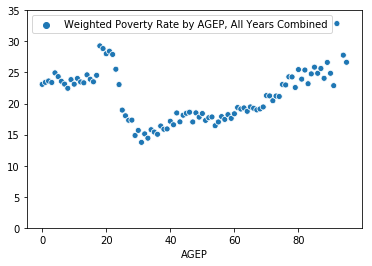

In [94]:
# Create a chart by all years combined for basic overview:

# Set up initial variables
n = 0
lookup = raw_inp_vars
weight = 'PWGTP' if lookup[n] in per_vars else 'WGTP'

# Create counts and percentages by column (lookup[n])
counts = cats[['NYCgov_Pov_Stat', lookup[n], weight]].groupby([lookup[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack().rename(columns={weight: 'Weighted Poverty Rate by ' + str(lookup[n]) + ', All Years Combined'})

# Show the chart
chart = sns.scatterplot(data=pcts)
chart.set_ylim(0,35)
pass